In [1]:
#| default_exp components

%load_ext autoreload
%autoreload 2


# Transformers components to be assembled in a model

Work in progress

In [2]:
#| export
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F

device = torch.device('mps')
torch.backends.mps.is_available()

True

## Embeddings

- Token embeddings, using torch embedding lookup
- Positional embedding, which can be fixed or learned.

In [3]:
#| export
class TokenEmbeddings(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim=embedding_dim)
        
    def forward(self, x):
        return self.embedding(x)

In [4]:
vocab_size = 6
embedding_dim = 50
emb = TokenEmbeddings(vocab_size, embedding_dim=embedding_dim)
emb.to(device)
x = torch.tensor([0,1,2,1], dtype=torch.long, device=device)
emb_x = emb(x)
assert emb_x.shape==(x.shape[0],embedding_dim)
assert torch.equal(emb_x[1],emb_x[3])

### Positional Encoding

As each word in a sentence simultaneously flows through the Transformer’s encoder/decoder stack, The model itself doesn’t have any sense of position/order for each word. Consequently, there’s still the need for a way to incorporate the order of the words into our model.
So we give the model some sense of position of the token in the sequence. 

Either we give the position as an input to the model or the model learns it.

#### Non learned positional embeddings

##### Potential solutions:

The first idea that might come to mind is to assign a number to each time-step within the [0, 1] range in which 0 means the first word and 1 is the last time-step. One of the problems it will introduce is that you can’t figure out how many words are present within a specific range. In other words, time-step delta doesn’t have consistent meaning across different sentences.

Another idea is to assign a number to each time-step linearly. That is, the first word is given “1”, the second word is given “2”, and so on. The problem with this approach is that not only the values could get quite large, but also our model can face sentences longer than the ones in training.

Ideally, the following criteria should be satisfied:

- It should output a unique encoding for each time-step (word’s position in a sentence)
- Distance between any two time-steps should be consistent across sentences with different lengths.
- Our model should generalize to longer sentences without any efforts. Its values should be bounded.
- It must be deterministic.

##### Proposed solutions:

The initial solution that was proposed isn’t a single number. Instead, it’s a d-dimensional vector that contains information about a specific position in a sentence. This vector, if not learned, is not integrated in the model.

$\begin{align}
  \vec{p_t}^{(i)} = f(t)^{(i)} & := 
  \begin{cases}
      \sin({\omega_k} . t),  & \text{if}\  i = 2k \\
      \cos({\omega_k} . t),  & \text{if}\  i = 2k + 1
  \end{cases}
\end{align} $

where $\omega_k = \frac{1}{n^{2k / d}}$

where : 
- L: sequence length
- t: position of token in input sequence
- d: dimension of positon embedding (same as token embedding)
- P(t,j): position function to map a position t in sequence to index (t,i) in positional matrix
- n: user defined scalar (ex: 10'000)
- i: index on the position embedding
- k: floor division (partie entière) of i by 2, so i = 2k (i is even - pair) or i=2k+1 (i is odd - impair), because we add a sin/cos pair on every two embedding slot

The frequency of sinusoidal is decreasing with the vector dimension (as i grows)

So we got a vector with pairs of sin/cosines for each frequency.

$\vec{p_t} = \begin{bmatrix} 
\sin({\omega_1}.t)\\ 
\cos({\omega_1}.t)\\ 
\\
\sin({\omega_2}.t)\\ 
\cos({\omega_2}.t)\\ 
\\
\vdots\\ 
\\
\sin({\omega_{d/2}}.t)\\ 
\cos({\omega_{d/2}}.t) 
\end{bmatrix}_{d \times 1}$

It's like the encoding of numbers in binary format: 

$
\begin{align}
  0: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} & & 
  8: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} \\
  1: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} & & 
  9: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} \\ 
  2: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} & & 
  10: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} \\ 
  3: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} & & 
  11: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{0}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} \\ 
  4: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} & & 
  12: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{0}} \\
  5: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} & & 
  13: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{0}} \ \ \color{red}{\texttt{1}} \\
  6: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} & & 
  14: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{0}} \\
  7: \ \ \ \ \color{orange}{\texttt{0}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} & & 
  15: \ \ \ \ \color{orange}{\texttt{1}} \ \ \color{green}{\texttt{1}} \ \ \color{blue}{\texttt{1}} \ \ \color{red}{\texttt{1}} \\
\end{align}$

where last bit is alternating on every number and previous on every 2 numbers, and so on. So instead of using bits (which would be a waste of space), we use continuous float variant with sinuosidal functions..

## References

- https://erdem.pl/2021/05/understanding-positional-encoding-in-transformers
- https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
- https://kikaben.com/transformers-positional-encoding/
- http://nlp.seas.harvard.edu/annotated-transformer/#positional-encoding




In [5]:
#| export

class PositionalEncoder(nn.Module):
    ''' Module to encode position in a transformer like model. 
    

    Args:
        max_seq_len (int): max length of sequence, aka L
        embedding_dim (int): dimension of embeddings in model, aka d
        dropout (float):  dropout rate. 0. for no dropout. 
        is_learned (bool): true if the position is learned through gradient descent or given (non differentiable) as defined in original paper Attention is all you need, https://arxiv.org/abs/1706.03762        
        n (int): user defined scalar set by default to 10000 as in paper        
    '''    
        
    def positional_encoding(self):
        pos = torch.arange(0,self.max_seq_len).repeat(self.embedding_dim, 1)
        i = torch.arange(0,self.embedding_dim)
        k = i // 2        
        wt = pos.T/(self.n**(2*k/self.embedding_dim))
        sin = torch.sin(wt)
        cos = torch.cos(wt)
        pe = torch.zeros((self.max_seq_len,self.embedding_dim))
        pe[:,0::2]= sin[:,0::2]
        pe[:,1::2]=cos[:,1::2]
        return pe

    def __init__(self, max_seq_len: int, embedding_dim: int, dropout: float = 0.,is_learned: bool = True, n:int=10000) -> None:
        super().__init__()
        self.max_seq_len = max_seq_len
        self.embedding_dim = embedding_dim
        self.is_learned = is_learned
        self.n = n
        self.dropout = nn.Dropout(p=dropout)
        if self.is_learned:            
            pos = torch.arange(0, self.max_seq_len, dtype=torch.long).unsqueeze(0) # shape (1, max_seq_len)
            self.register_buffer('pos', pos)
            self.pos_embedding = nn.Embedding(max_seq_len, embedding_dim)
        else:
            pos_encodings = self.positional_encoding().unsqueeze(0)
            pos_encodings.requires_grad_(False)
            # a buffer is a state in module which is not a parameter (learned)
            self.register_buffer('pos_encodings',pos_encodings)

            
    def forward(self, x):
        if self.is_learned:            
            x = x + self.pos_embedding(self.pos)
        else:
            x= x + self.pos_encodings
        return self.dropout(x)            
                        
 

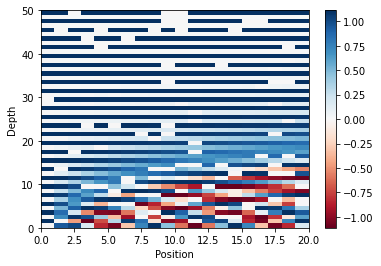

In [6]:

seq_len = 20
embedding_dim = 50
pos_enc = PositionalEncoder(max_seq_len=seq_len, embedding_dim=embedding_dim, dropout=0.1, is_learned=False) 
pos_enc.to(device)
pos_enc.positional_encoding()       
x = torch.zeros(1, seq_len, embedding_dim, device=device)
pe = pos_enc.forward(x)
np_pe = pe.cpu().detach().numpy()
plt.pcolormesh(np_pe[0].T, cmap='RdBu')
plt.xlabel('Position')
plt.ylabel('Depth')
plt.colorbar()
plt.show()

## Attention mechanisms

### attention function

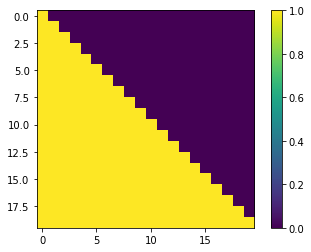

In [50]:
def unidirectional_mask(seq_len:int):
    inverse_mask = torch.triu(torch.ones((1, seq_len,seq_len)), diagonal=1)
    mask = inverse_mask==0
    return mask

mask = unidirectional_mask(20)

plt.imshow(mask[0])
plt.colorbar()
plt.show()
    
    

In [27]:
def attention(query: torch.TensorType, key: torch.TensorType, value: torch.TensorType, mask: torch.TensorType=None, dropout:float=0.):
    d_k = query.size(-1)
    S = key.transpose(-2,-1) @ query
    F.softmax(S/torch.sqrt(torch.tensor(d_k, requires_grad=False)), dim=-1)
    return S
    
g = torch.Generator().manual_seed(42)
Q = torch.randn((1, seq_len, embedding_dim),generator=g, device=device)    
K = torch.randn((1, seq_len, embedding_dim),generator=g, device=device)    
V = torch.randn((1, seq_len, embedding_dim),generator=g, device=device)    
print(seq_len, embedding_dim)
attention(Q,K,V).shape


20 50


torch.Size([1, 50, 50])

In [7]:
#| export


class MultiHeadAttention(nn.Module):
    def __init__(self, d:int):
        super().__init__()
        g = torch.Generator().manual_seed(42)        
        self.d = d
        self.w_weights = torch.randn((d, d_in), generator=g)
        self.k_weights = torch.randn((d, d_in), generator=g)
        self.v_weights = torch.randn((d, d_in), generator=g)
        

    def forward(self, x):
        ...


e = torch.rand((1,seq_len, embedding_dim))
attn = MultiHeadAttention(d_in=embedding_dim, d=embedding_dim)
attn(e)

In [ ]:
# test with multihead_attn = nn.MultiheadAttention(embed_dim, num_heads) so that result is the same. 

In [37]:
#| hide
import nbdev; nbdev.nbdev_export("./components.ipynb")